### Plotting alignment data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import csv
import pandas as pd
import utils.db_utils as db
import utils.plot_utils as plot
import utils.file_utils as file

bibleType = 'en_ult'
type_ = 'kt'
dbPath = f'./data/{bibleType}_NT_alignments.sqlite'

connection = db.initAlignmentDB(dbPath)

Connection to SQLite DB successful


In [7]:
# get alignments for tW keyterms

minAlignments = 40
remove = ['ὁ', 'τίθημι', 'ποιέω', 'ἀμήν', 'ἐξουσία', 'μέν']
alignmentsForWord, filteredAlignmentsForWord = db.fetchAlignmentDataForLemmasCached(connection, type_, bibleType, minAlignments, remove)
print(f"Original Language Alignments: {len(filteredAlignmentsForWord)}")

Using cached Alignments
Unfiltered Alignments: 4367
getFilteredAlignmentsForWord - rejecting ἀμὴν lemma in remove list ἀμήν
getFilteredAlignmentsForWord - rejecting ἐποίησεν lemma in remove list ποιέω
getFilteredAlignmentsForWord - rejecting ποιῆσαι lemma in remove list ποιέω
getFilteredAlignmentsForWord - rejecting ἐξουσίαν lemma in remove list ἐξουσία
getFilteredAlignmentsForWord - rejecting τὸν lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τοὺς lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τῆς lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τοῦ lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τὴν lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting αἱ lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting ἡ lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τῷ lemma in remove list ὁ
getFilteredAlignmentsForWord - rejecting τὸ lemma in remove list ὁ
getFilteredAlignmentsForWord - rejec

In [8]:
# find all alignments for this original word

# word = 'Θεός' # found 69
# word = 'Θεὸς' # found 239
# word = 'Θεοῦ'  # found 712
# origAlignments = getDataFrameForOriginalWords(connection, word, searchLemma = False)
# origAlignments

### Analysis of alignments for keyterms in the en_ult:

#### Frequency of alignments:
_***Note that each line on the graphs below represents an alignment for a specific word. For example we have separate lines for 'Θεός', 'Θεὸς', or 'Θεοῦ' even though they have the same lemma.  It made sense to group the alignments this way since aligners are likely to choose different target language words based on morphology of the word._

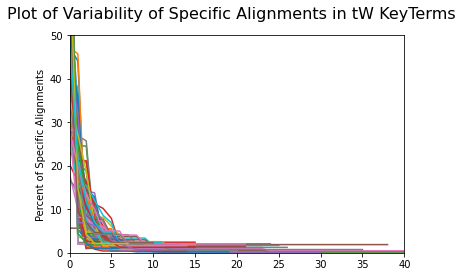

In [19]:
frequenciesOfAlignments = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, 'alignmentTxt')

title = f"Plot of Variability of Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlimit = [0, 40]
plot.plotFrequencies(frequenciesOfAlignments, title, ylabel, showXValues=False, xlimit=xlimit)

stats = []
for word in frequenciesOfAlignments.keys():
    frequency = frequenciesOfAlignments[word]
    counts = list(frequency.values)
    countsSeries = pd.Series(counts).describe()
    # for key in frequency.keys():
    #     count = frequency[key]
    #     countStr = str(count)
    #     if count in counts:
    #         counts[countStr] += 1
    #     else:
    #         counts[countStr] = 1
    alignments = filteredAlignmentsForWord[word]
    # for alignment in alignments:
    #     found = db.findOriginalLanguageWord(alignment['origWords'], word, checkLemmas=False)
    #     if not found:
    #         print(f"Alignment does not have original lang '{word}: {alignment}")
    stats.append({
        'originalWord': word,
        'alignments': alignments,
        'frequency': frequency,
        'counts': counts,
        'countsSeries': countsSeries
    })

### Analysis:

#### Analysis of numerical metrics:

#### Analysis of original language word count:

Found 100 original language words for tW type kt


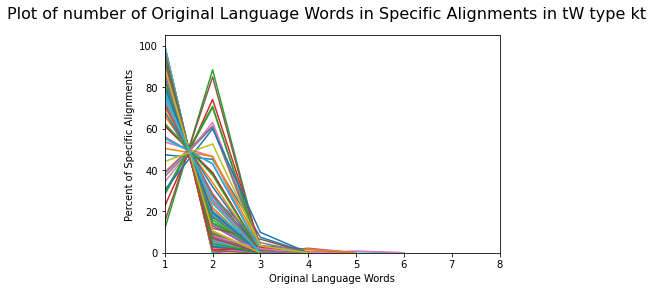

In [10]:
field = 'alignmentOrigWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

print(f"Found {len(field_frequencies)} original language words for tW type {type_}")
title = f"Plot of number of Original Language Words in Specific Alignments in tW type {type_}"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])


##### Notes:
- this field analysis suggests that original word counts are tight - a threshold word count of 3 probably good for English to flag for review.
<p></p>

Out of 100, found 2 original language words that have instances with over 4 words


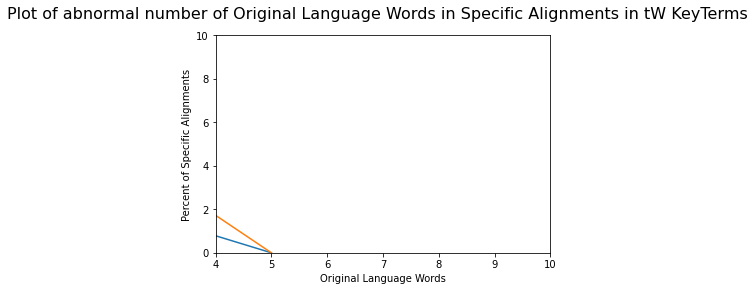

In [11]:
threshold = 4
abnormalAlignments = {}
for origWord in field_frequencies:
    frequency = field_frequencies[origWord]
    count = len(frequency)
    if count >= threshold:
        abnormalAlignments[origWord] = frequency

print(f"Out of {len(field_frequencies)}, found {len(abnormalAlignments)} original language words that have instances with over {threshold} words")
filledFrequencies = db.zeroFillFrequencies(abnormalAlignments)

title = f"Plot of abnormal number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[threshold, 10], ylimit=[0, 10])

#### Analysis of target language word count:

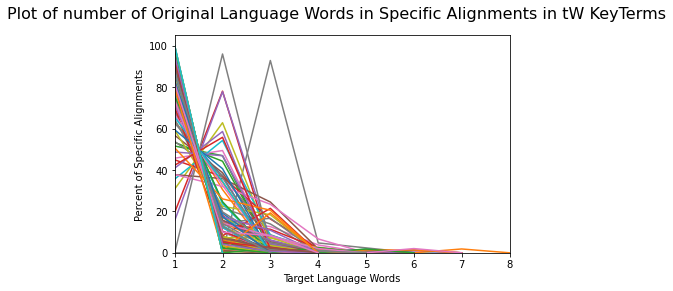

In [12]:
field = 'alignmentTargetWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Target Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])

##### Notes:
- this field analysis suggests that a threshold word count of 3 probably good for English to flag for review.
<p></p>

#### Analysis of count of extra unaligned words between aligned original language words:

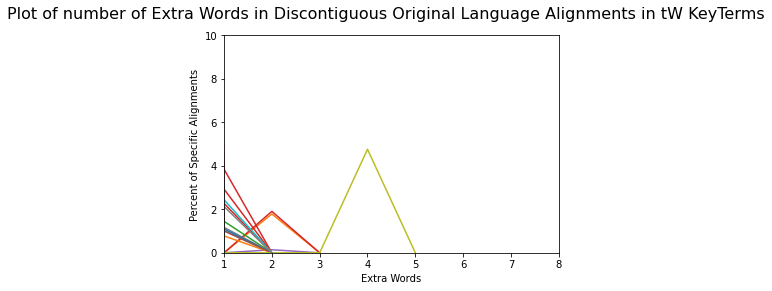

In [14]:
field = 'origWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Original Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8], ylimit=[0,10])

##### Notes:
- this field analysis suggests that most original language alignments probably good. Probably the cases of a word between aligned words should be reviewed.
<p></p>

#### Analysis of count of extra unaligned words between aligned target language words:

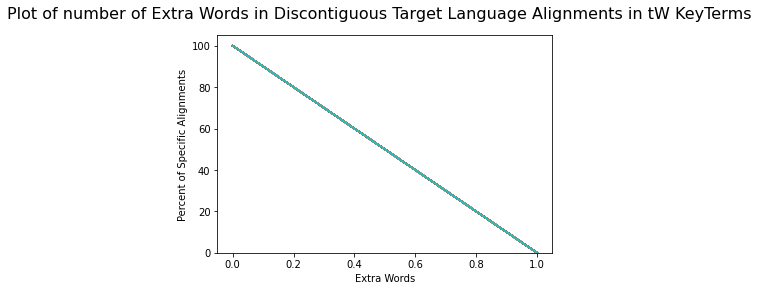

In [15]:
field = 'targetWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Target Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that most target language alignments are very tight.

#### Generate CSV of questionable alignments:

In [16]:
alignmentOrigWordsThreshold = 3
alignmentTargetWordsThreshold = 5
origWordsBetweenThreshold = 1
targetWordsBetweenThreshold = 1
warningData = db.generateWarnings(type_, bibleType, filteredAlignmentsForWord, alignmentOrigWordsThreshold,
                                  alignmentTargetWordsThreshold, origWordsBetweenThreshold, targetWordsBetweenThreshold)
print(f"Found {len(warningData)} alignments to check")

Found 150 alignments to check
